In [728]:
import pysal as ps
import pandas as pd
import geopandas as gpd
from datetime import datetime
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.cm as cmx
import numpy as np
import seaborn as sns
import contextily as ctx
import matplotlib.cm as cm
import math
from sklearn.metrics import silhouette_score

from shapely.geometry import Point, Polygon
from sklearn.cluster import KMeans

# Importing data

### Taxi trip data for June, 2016:

In [13]:
data = pd.read_csv("taxi_data/2016_Yellow_Taxi_Trip_Data_June.csv") 

In [14]:
data['index'] = data.index
data['tpep_pickup_datetime'] = pd.to_datetime(data['tpep_pickup_datetime'])
data['tpep_dropoff_datetime'] = pd.to_datetime(data['tpep_dropoff_datetime'])

# We will use geodataframes, which can only have one geometry column per dataframe.
# To address this constraint, we'll make a gdf for the dropoff coordinates, and one for the pickup coordinates

data_dropoff = data.copy()
data_pickup = data.copy()
data.head(2)

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,pickup_longitude,pickup_latitude,RatecodeID,store_and_fwd_flag,dropoff_longitude,...,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,PULocationID,DOLocationID,index
0,1,2016-06-06,2016-06-06 00:16:57,1,6.60,-73.946548,40.785099,1,N,-73.923866,...,20.0,0.5,0.5,0.0,0.00,0.3,21.30,NaN,NaN,0
1,2,2016-06-06,2016-06-06 00:00:00,1,4.27,-73.952385,40.741501,2,N,-74.004097,...,52.0,0.0,0.5,0.0,5.54,0.3,58.34,NaN,NaN,1


## EDA and SEDA

In [15]:
data.shape

(2626851, 22)

In [16]:
data.dtypes

VendorID                          int64
tpep_pickup_datetime     datetime64[ns]
tpep_dropoff_datetime    datetime64[ns]
passenger_count                   int64
trip_distance                   float64
pickup_longitude                float64
pickup_latitude                 float64
RatecodeID                        int64
store_and_fwd_flag               object
dropoff_longitude               float64
dropoff_latitude                float64
payment_type                      int64
fare_amount                     float64
extra                           float64
mta_tax                         float64
tip_amount                      float64
tolls_amount                    float64
improvement_surcharge           float64
total_amount                    float64
PULocationID                    float64
DOLocationID                    float64
index                             int64
dtype: object

In [17]:
df = data
df['tpep_pickup_datetime']

0         2016-06-06 00:00:00
1         2016-06-06 00:00:00
2         2016-06-06 00:00:00
3         2016-06-06 00:00:01
4         2016-06-06 00:00:02
                  ...        
2626846   2016-06-13 00:00:00
2626847   2016-06-13 00:00:00
2626848   2016-06-13 00:00:00
2626849   2016-06-13 00:00:00
2626850   2016-06-13 00:00:00
Name: tpep_pickup_datetime, Length: 2626851, dtype: datetime64[ns]

### Importing data for Borough and Taxi Zone boundaries

In [18]:
# path_to_zones_1 = 'taxi_data/NYC_Taxi_Zones/geo_export_548af4a7-9434-4e42-ad4e-719bbf8aa21d.shp'
# path_to_zones_2 = 'taxi_data/taxi_zones/taxi_zones.shp'
# df_bb = gpd.read_file('taxi_data/Borough Boundaries.geojson')


zones = gpd.read_file('taxi_data/NYCTaxiZones.geojson')
zones.head(10)


,shape_area,objectid,shape_leng,location_id,zone,borough,geometry
0,0.0007823067885,1,0.116357453189,1,Newark Airport,EWR,"MULTIPOLYGON (((-74.18445 40.69500, -74.18449 ..."
1,0.00486634037837,2,0.43346966679,2,Jamaica Bay,Queens,"MULTIPOLYGON (((-73.82338 40.63899, -73.82277 ..."
2,0.000314414156821,3,0.0843411059012,3,Allerton/Pelham Gardens,Bronx,"MULTIPOLYGON (((-73.84793 40.87134, -73.84725 ..."
3,0.000111871946192,4,0.0435665270921,4,Alphabet City,Manhattan,"MULTIPOLYGON (((-73.97177 40.72582, -73.97179 ..."
4,0.000497957489363,5,0.0921464898574,5,Arden Heights,Staten Island,"MULTIPOLYGON (((-74.17422 40.56257, -74.17349 ..."
5,0.000606460984581,6,0.150490542523,6,Arrochar/Fort Wadsworth,Staten Island,"MULTIPOLYGON (((-74.06367 40.60220, -74.06351 ..."
6,0.000389787989274,7,0.107417171123,7,Astoria,Queens,"MULTIPOLYGON (((-73.90414 40.76752, -73.90325 ..."
7,0.000026587716279,8,0.0275906911574,8,Astoria Park,Queens,"MULTIPOLYGON (((-73.92334 40.77513, -73.92398 ..."
8,0.000338443803197,9,0.0997840924705,9,Auburndale,Queens,"MULTIPOLYGON (((-73.78502 40.76104, -73.78486 ..."
9,0.0000607235737749,24,0.0469999619287,24,Bloomingdale,Manhattan,"MULTIPOLYGON (((-73.95954 40.79872, -73.96004 ..."


In [357]:
zones.crs  = {'init' :'epsg:4326'}
#zones.crs = {'init' :'epsg:3857'}


/Users/isaurr/opt/anaconda3/envs/env_pysal/lib/python3.7/site-packages/pyproj/crs/crs.py:55: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


We can see our the taxi zones over a layer of a map of NYC using contextily:

In [665]:
def add_basemap(ax, zoom, url='http://tile.stamen.com/terrain/tileZ/tileX/tileY.png'):
    xmin, xmax, ymin, ymax = ax.axis()
    basemap, extent = ctx.bounds2img(xmin, ymin, xmax, ymax, zoom=zoom, url=url)
    ax.imshow(basemap, extent=extent, interpolation='bilinear', alpha = 0.3)
    # restore original x/y limits
    ax.axis((xmin, xmax, ymin, ymax))

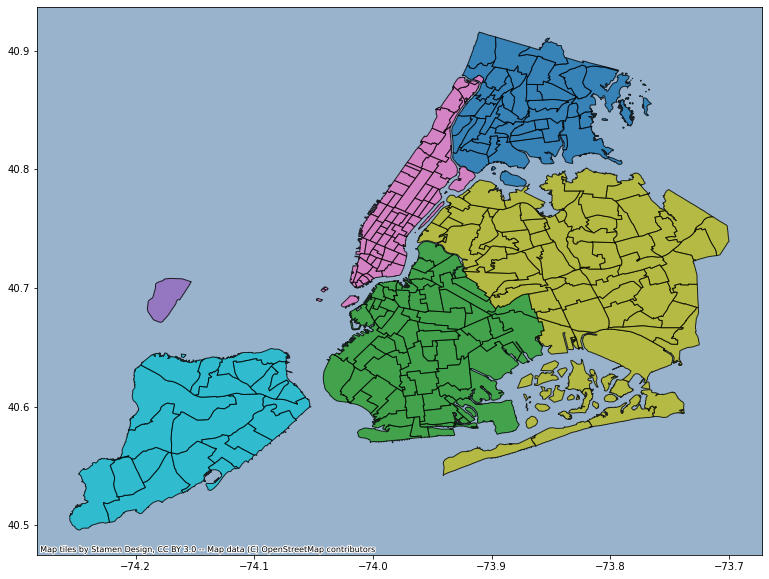

In [666]:
fig, ax = plt.subplots(figsize = (13,13))
zones.plot(column='borough', categorical=True, ax = ax, alpha = 0.8, edgecolor = 'k')
ctx.add_basemap(ax, zoom = 12)
plt.savefig('zones.jpg')

In [22]:
# We check that the projections for the dropoff/pickup locations, and the taxi zones are the same
zones.crs

<Geographic 2D CRS: +init=epsg:4326 +type=crs>
Name: WGS 84
Axis Info [ellipsoidal]:
- lon[east]: Longitude (degree)
- lat[north]: Latitude (degree)
Area of Use:
- name: World
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

## Populating missing columns:

TODO: This should be one function

Note that the geodataframe for the pickup/dropoff locations are missing the taxi zone number.

We populate this column by querying the taxi zone of each pickup/dropoff location using a spatial join.

In [23]:
gdf_p = gpd.GeoDataFrame(
    data_pickup, geometry=gpd.points_from_xy(data_pickup.pickup_longitude, data_pickup.pickup_latitude))
gdf_p.head()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,pickup_longitude,pickup_latitude,RatecodeID,store_and_fwd_flag,dropoff_longitude,...,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,PULocationID,DOLocationID,index,geometry
0,1,2016-06-06 00:00:00,2016-06-06 00:16:57,1,6.60,-73.946548,40.785099,1,N,-73.923866,...,0.5,0.5,0.00,0.00,0.3,21.30,NaN,NaN,0,POINT (-73.94655 40.78510)
1,2,2016-06-06 00:00:00,2016-06-06 00:00:00,1,4.27,-73.952385,40.741501,2,N,-74.004097,...,0.0,0.5,0.00,5.54,0.3,58.34,NaN,NaN,1,POINT (-73.95238 40.74150)
2,2,2016-06-06 00:00:00,2016-06-06 18:07:49,1,2.02,-73.978745,40.750641,1,N,-73.997108,...,1.3,0.5,1.25,0.00,0.3,13.35,NaN,NaN,2,POINT (-73.97874 40.75064)
3,2,2016-06-06 00:00:01,2016-06-06 00:04:05,2,1.37,-73.980690,40.742210,1,N,-73.967842,...,0.5,0.5,1.82,0.00,0.3,9.12,NaN,NaN,3,POINT (-73.98069 40.74221)
4,1,2016-06-06 00:00:02,2016-06-06 00:03:36,1,0.90,-73.986794,40.756310,1,N,-73.976067,...,0.5,0.5,0.00,0.00,0.3,6.30,NaN,NaN,4,POINT (-73.98679 40.75631)


In [24]:
gdf_d = gpd.GeoDataFrame(
    data_dropoff, geometry=gpd.points_from_xy(data_dropoff.dropoff_longitude, data_dropoff.dropoff_latitude))
gdf_d.head()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,pickup_longitude,pickup_latitude,RatecodeID,store_and_fwd_flag,dropoff_longitude,...,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,PULocationID,DOLocationID,index,geometry
0,1,2016-06-06 00:00:00,2016-06-06 00:16:57,1,6.60,-73.946548,40.785099,1,N,-73.923866,...,0.5,0.5,0.00,0.00,0.3,21.30,NaN,NaN,0,POINT (-73.92387 40.80770)
1,2,2016-06-06 00:00:00,2016-06-06 00:00:00,1,4.27,-73.952385,40.741501,2,N,-74.004097,...,0.0,0.5,0.00,5.54,0.3,58.34,NaN,NaN,1,POINT (-74.00410 40.72091)
2,2,2016-06-06 00:00:00,2016-06-06 18:07:49,1,2.02,-73.978745,40.750641,1,N,-73.997108,...,1.3,0.5,1.25,0.00,0.3,13.35,NaN,NaN,2,POINT (-73.99711 40.72501)
3,2,2016-06-06 00:00:01,2016-06-06 00:04:05,2,1.37,-73.980690,40.742210,1,N,-73.967842,...,0.5,0.5,1.82,0.00,0.3,9.12,NaN,NaN,3,POINT (-73.96784 40.75903)
4,1,2016-06-06 00:00:02,2016-06-06 00:03:36,1,0.90,-73.986794,40.756310,1,N,-73.976067,...,0.5,0.5,0.00,0.00,0.3,6.30,NaN,NaN,4,POINT (-73.97607 40.76312)


In [25]:
# Check projections
print(gdf_p.crs, gdf_d.crs)

gdf_p.crs = {'init' :'epsg:3857'}
gdf_d.crs = {'init' :'epsg:3857'}

None None


/Users/isaurr/opt/anaconda3/envs/env_pysal/lib/python3.7/site-packages/pyproj/crs/crs.py:55: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


In [391]:
# Check the size of the gdf:
gdf_d.shape

geopandas.geodataframe.GeoDataFrame

In [27]:
# Create an index column for reference later
gdf_d['index'] = gdf_d.index
gdf_p['index'] = gdf_p.index

### Create dataframes for spatial join
We create dataframe with the information we need for a spatial join:

In [28]:
# Inspect gdf_dj
gdf_dj= gdf_d[['index','geometry']]
gdf_dj.head()

,index,geometry
0,0,POINT (-73.92387 40.80770)
1,1,POINT (-74.00410 40.72091)
2,2,POINT (-73.99711 40.72501)
3,3,POINT (-73.96784 40.75903)
4,4,POINT (-73.97607 40.76312)


In [29]:
# Inspect gdf_pj
gdf_pj= gdf_p[['index','geometry']]
gdf_pj.head()

,index,geometry
0,0,POINT (-73.94655 40.78510)
1,1,POINT (-73.95238 40.74150)
2,2,POINT (-73.97874 40.75064)
3,3,POINT (-73.98069 40.74221)
4,4,POINT (-73.98679 40.75631)


In [30]:
zones_z = zones[['zone','geometry']]

In [31]:
zones_z.head()

,zone,geometry
0,Newark Airport,"MULTIPOLYGON (((-74.18445 40.69500, -74.18449 ..."
1,Jamaica Bay,"MULTIPOLYGON (((-73.82338 40.63899, -73.82277 ..."
2,Allerton/Pelham Gardens,"MULTIPOLYGON (((-73.84793 40.87134, -73.84725 ..."
3,Alphabet City,"MULTIPOLYGON (((-73.97177 40.72582, -73.97179 ..."
4,Arden Heights,"MULTIPOLYGON (((-74.17422 40.56257, -74.17349 ..."


In [66]:
zones_z.shape

(263, 2)

In [32]:
pickups_with_zones = gpd.sjoin(gdf_pj, zones_z, how="left", op='intersects')

/Users/isaurr/opt/anaconda3/envs/env_pysal/lib/python3.7/site-packages/geopandas/tools/sjoin.py:61: UserWarning: CRS of frames being joined does not match!(+init=epsg:3857 +type=crs != +init=epsg:4326 +type=crs)
  "(%s != %s)" % (left_df.crs, right_df.crs)


In [38]:
dropoff_with_zones = gpd.sjoin(gdf_dj, zones_z, how="left", op='intersects')

/Users/isaurr/opt/anaconda3/envs/env_pysal/lib/python3.7/site-packages/geopandas/tools/sjoin.py:61: UserWarning: CRS of frames being joined does not match!(+init=epsg:3857 +type=crs != +init=epsg:4326 +type=crs)
  "(%s != %s)" % (left_df.crs, right_df.crs)


Note that there's an error in the crs cordinates, the joins work gdf_pj and gdf_dj are 3857, and zones is in 4326.

In [50]:
# Check to see what the gdf look like after the joins:
pickups_with_zones.sort_index().head(3)
# pickups_with_zones.sort_index().head(10)

,index,geometry,index_right,zone
0,0,POINT (-73.94655 40.78510),78.0,East Harlem South
1,1,POINT (-73.95238 40.74150),148.0,Long Island City/Hunters Point
2,2,POINT (-73.97874 40.75064),164.0,Murray Hill


In [49]:
# Double check that our dataframes are the right shape
print(pickups_with_zones.shape, dropoff_with_zones.shape, df.shape)

(2626851, 4) (2626851, 4) (2626851, 22)


It is interesting to note that not all taxi zones were serviced by yellow taxi cabs:


In [51]:
# Checking number of trips in zones:
print(pickups_with_zones['zone'].nunique(), dropoff_with_zones['zone'].nunique(),zones_z['zone'].nunique())
# We dig into this a little further to investigate:
check_zone_d = zones_z.copy()
check_zone_p = zones_z.copy()
count_d = check_zone_d.groupby(['zone']).count()
count_p = check_zone_p.groupby(['zone']).count()

250 255 260


### Add taxi zones to pickup/dropoff gdfs
We add zones to df in the PULocationID and DOLocationID columns.


In [52]:
# Add suffixes to column names before merging gdfs:
pickups_with_zones.columns = 'PU_' + pickups_with_zones.columns.values
dropoff_with_zones.columns = 'DO_' + dropoff_with_zones.columns.values

In [53]:
pickups_with_zones.rename(columns={"PU_index": "index"}, inplace = True)
dropoff_with_zones.rename(columns={"DO_index": "index"}, inplace = True)

In [54]:
pickups_with_zones.head()

,index,PU_geometry,PU_index_right,PU_zone
0,0,POINT (-73.94655 40.78510),78.0,East Harlem South
1,1,POINT (-73.95238 40.74150),148.0,Long Island City/Hunters Point
2,2,POINT (-73.97874 40.75064),164.0,Murray Hill
3,3,POINT (-73.98069 40.74221),164.0,Murray Hill
4,4,POINT (-73.98679 40.75631),229.0,Times Sq/Theatre District


In [55]:
df_PU = pd.merge(df, pickups_with_zones, on=['index'], how = 'left')
df_DO = pd.merge(df, dropoff_with_zones, on=['index'], how = 'left')

In [57]:
df_PU.head(1)

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,pickup_longitude,pickup_latitude,RatecodeID,store_and_fwd_flag,dropoff_longitude,...,tip_amount,tolls_amount,improvement_surcharge,total_amount,PULocationID,DOLocationID,index,PU_geometry,PU_index_right,PU_zone
0,1,2016-06-06,2016-06-06 00:16:57,1,6.6,-73.946548,40.785099,1,N,-73.923866,...,0.0,0.0,0.3,21.3,NaN,NaN,0,POINT (-73.94655 40.78510),78.0,East Harlem South


In [58]:
df_zones = pd.merge(df_PU, df_DO, on=['index'], how = 'left')

In [59]:
df_zones.columns

Index(['VendorID_x', 'tpep_pickup_datetime_x', 'tpep_dropoff_datetime_x',
       'passenger_count_x', 'trip_distance_x', 'pickup_longitude_x',
       'pickup_latitude_x', 'RatecodeID_x', 'store_and_fwd_flag_x',
       'dropoff_longitude_x', 'dropoff_latitude_x', 'payment_type_x',
       'fare_amount_x', 'extra_x', 'mta_tax_x', 'tip_amount_x',
       'tolls_amount_x', 'improvement_surcharge_x', 'total_amount_x',
       'PULocationID_x', 'DOLocationID_x', 'index', 'PU_geometry',
       'PU_index_right', 'PU_zone', 'VendorID_y', 'tpep_pickup_datetime_y',
       'tpep_dropoff_datetime_y', 'passenger_count_y', 'trip_distance_y',
       'pickup_longitude_y', 'pickup_latitude_y', 'RatecodeID_y',
       'store_and_fwd_flag_y', 'dropoff_longitude_y', 'dropoff_latitude_y',
       'payment_type_y', 'fare_amount_y', 'extra_y', 'mta_tax_y',
       'tip_amount_y', 'tolls_amount_y', 'improvement_surcharge_y',
       'total_amount_y', 'PULocationID_y', 'DOLocationID_y', 'DO_geometry',
       'DO_index

In [60]:
df_zones_copy = df_zones.copy()

In [61]:
df_zones = df_zones[['index', 'passenger_count_x', 'trip_distance_x', 
                     'tpep_pickup_datetime_x', 'tpep_dropoff_datetime_x', 
                     'PU_index_right', 'PU_zone', 'DO_index_right', 'DO_zone',
                    'passenger_count_x', 'trip_distance_x', 'pickup_longitude_x','pickup_latitude_x',
                    'dropoff_longitude_x','dropoff_latitude_x']]

df_zones = df_zones.rename(columns={'passenger_count_x':'passenger_count', 'trip_distance_x':'trip_distance',
                         'tpep_pickup_datetime_x':'PU_time', 'tpep_dropoff_datetime_x':'DO_time',
                        'passenger_count_x':'passenger_count', 'trip_distance_x':'trip_distance', 
                         'DO_index_right': 'DO_index', 'PU_index_right': 'PU_index',
                         'pickup_longitude_x':'PU_long','pickup_latitude_x':'PU_lat',
                        'dropoff_longitude_x':'DO_long','dropoff_latitude_x':'DO_lat'})

df_zones.head(1)

,index,passenger_count,trip_distance,PU_time,DO_time,PU_index,PU_zone,DO_index,DO_zone,passenger_count,trip_distance,PU_long,PU_lat,DO_long,DO_lat
0,0,1,6.6,2016-06-06,2016-06-06 00:16:57,78.0,East Harlem South,169.0,Mott Haven/Port Morris,1,6.6,-73.946548,40.785099,-73.923866,40.807705


In [62]:
df_zones.columns

Index(['index', 'passenger_count', 'trip_distance', 'PU_time', 'DO_time',
       'PU_index', 'PU_zone', 'DO_index', 'DO_zone', 'passenger_count',
       'trip_distance', 'PU_long', 'PU_lat', 'DO_long', 'DO_lat'],
      dtype='object')

# Make a whole bunch of exploratory plots.
### Rides by zone

In [133]:
PU_count = df_zones.copy()
DO_count = df_zones.copy()

In [137]:
# def group_by_zone(zones_count, index_col, zone_col):
#     """Takes a dataframe with zones, outputs dataframe with ride counts (not passenger counts!)"""
#     result = zones_count.groupby(zone_col).count()
#     result = result.reset_index()
#     result = result[[index_col, zone_col]]
#     result = result.rename(columns={str(index_col): "count", str(zone_col): 'zone'})
#     return result

In [141]:
resultPU = PU_count.groupby('PU_zone').count()
resultPU = resultPU.reset_index()
resultPU = resultPU[['PU_zone','index']]
resultPU = resultPU.rename(columns={"index": "count", 'PU_zone': 'zone'})
resultPU.head(2)

,zone,count
0,Allerton/Pelham Gardens,13
1,Alphabet City,8000


In [142]:
resultDO = DO_count.groupby('DO_zone').count()
resultDO = resultDO.reset_index()
resultDO = resultDO[['DO_zone','index']]
resultDO = resultDO.rename(columns={"index": "count", 'DO_zone': 'zone'})
resultDO.head(2)

,zone,count
0,Allerton/Pelham Gardens,152
1,Alphabet City,13257


In [105]:
zones_DO = gpd.GeoDataFrame(pd.merge(zones_z, resultDO, how='left', on='zone'))
zones_PU = gpd.GeoDataFrame(pd.merge(zones_z, resultPU, how='left', on='zone'))

In [108]:
zones_DO.head()

,zone,geometry,count
0,Newark Airport,"MULTIPOLYGON (((-74.18445 40.69500, -74.18449 ...",5023.0
1,Jamaica Bay,"MULTIPOLYGON (((-73.82338 40.63899, -73.82277 ...",NaN
2,Allerton/Pelham Gardens,"MULTIPOLYGON (((-73.84793 40.87134, -73.84725 ...",152.0
3,Alphabet City,"MULTIPOLYGON (((-73.97177 40.72582, -73.97179 ...",13257.0
4,Arden Heights,"MULTIPOLYGON (((-74.17422 40.56257, -74.17349 ...",14.0


### Drop offs over the whole week:

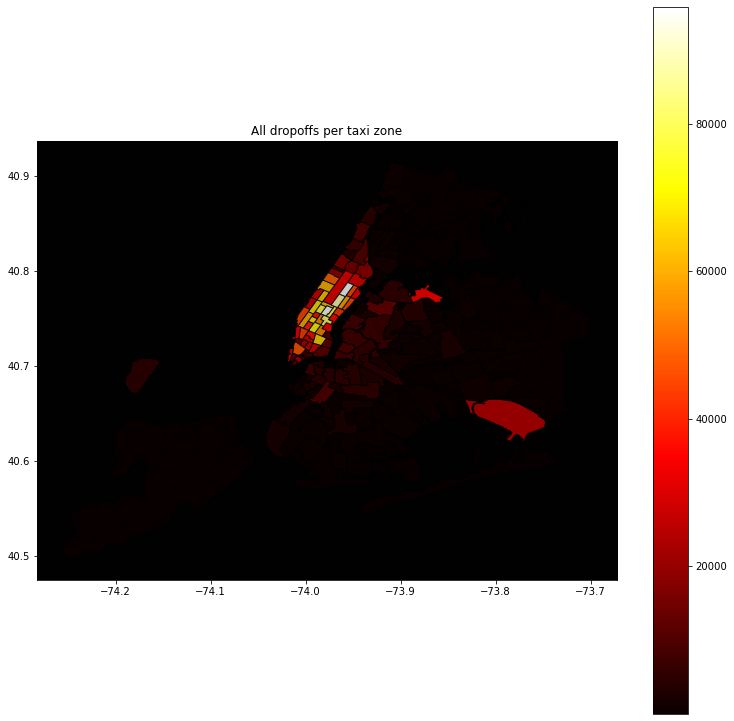

In [441]:
fig, ax = plt.subplots(figsize = (13,13))
zones_DO.plot(column='count', categorical=False, ax = ax, alpha = 0.8, edgecolor = 'k', legend = True, cmap = 'hot')
plt.title("All dropoffs per taxi zone")
#im = ax.imshow(np.arange(100).reshape((10,10)))
#plt.colorbar(fraction=0.046, pad=0.04)
#plt.legend(loc='upper left', prop={"size":20})
ctx.add_basemap(ax = ax, zoom = 12, url = ctx.sources.ST_TONER_BACKGROUND)
plt.savefig('dropoffs_byzone.jpg')

### Pickups over the whole week:

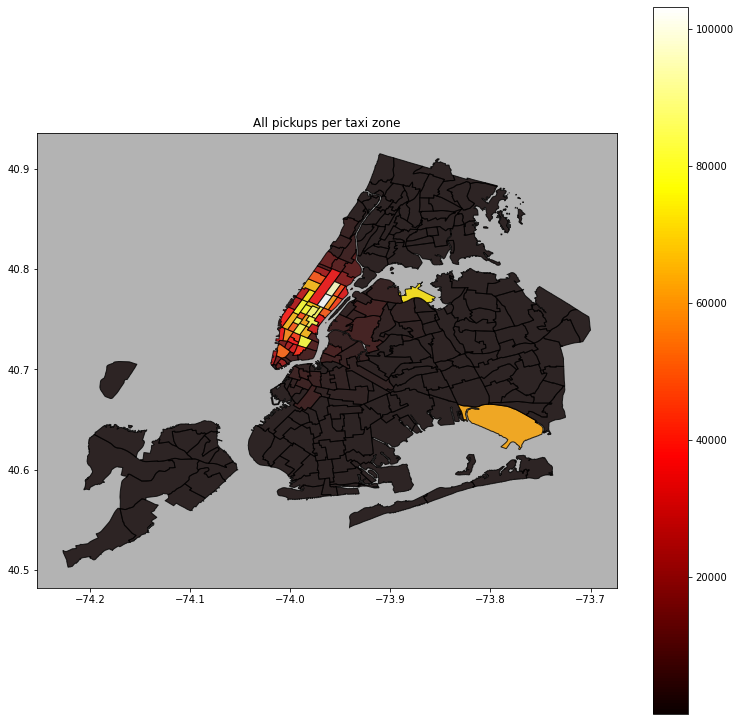

In [625]:
fig, ax = plt.subplots(figsize = (13,13))
zones_PU.plot(column='count', categorical=False, ax = ax, alpha = 0.8, edgecolor = 'k', legend = True, h)
plt.title("All pickups per taxi zone")
plt.savefig('pickups_byzone.jpg')
add_basemap(ax, zoom = 12, url = ctx.sources.ST_TONER_BACKGROUND)



In [239]:
df.head()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,pickup_longitude,pickup_latitude,RatecodeID,store_and_fwd_flag,dropoff_longitude,...,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,PULocationID,DOLocationID,index
0,1,2016-06-06 00:00:00,2016-06-06 00:16:57,1,6.60,-73.946548,40.785099,1,N,-73.923866,...,20.0,0.5,0.5,0.00,0.00,0.3,21.30,NaN,NaN,0
1,2,2016-06-06 00:00:00,2016-06-06 00:00:00,1,4.27,-73.952385,40.741501,2,N,-74.004097,...,52.0,0.0,0.5,0.00,5.54,0.3,58.34,NaN,NaN,1
2,2,2016-06-06 00:00:00,2016-06-06 18:07:49,1,2.02,-73.978745,40.750641,1,N,-73.997108,...,10.0,1.3,0.5,1.25,0.00,0.3,13.35,NaN,NaN,2
3,2,2016-06-06 00:00:01,2016-06-06 00:04:05,2,1.37,-73.980690,40.742210,1,N,-73.967842,...,6.0,0.5,0.5,1.82,0.00,0.3,9.12,NaN,NaN,3
4,1,2016-06-06 00:00:02,2016-06-06 00:03:36,1,0.90,-73.986794,40.756310,1,N,-73.976067,...,5.0,0.5,0.5,0.00,0.00,0.3,6.30,NaN,NaN,4


### Hourly breakdown
Aggregate over time buckets.

In [537]:
df_zones.dtypes

index                       int64
passenger_count             int64
trip_distance             float64
PU_time            datetime64[ns]
DO_time            datetime64[ns]
PU_index                  float64
PU_zone                    object
DO_index                  float64
DO_zone                    object
passenger_count             int64
trip_distance             float64
PU_long                   float64
PU_lat                    float64
DO_long                   float64
DO_lat                    float64
PU_day                      int64
PU_hour                     int64
DO_day                      int64
DO_hour                     int64
PU_day_nm                  object
DO_day_nm                  object
Norm_x                    float64
Norm_y                    float64
dtype: object

In [541]:
#  def hourly_demand(df):
#    """ Input data frame, outputs dataframe grouped by hour."""
df_zones_copy = df_zones

In [540]:
df_zones_copy = df_zones.copy()

In [534]:
df_zones_copy['PU_day'] = df_zones_copy['PU_time'].dt.day
df_zones_copy['PU_hour'] = df_zones_copy['PU_time'].dt.hour
df_zones_copy['DO_day'] = df_zones_copy['DO_time'].dt.day
df_zones_copy['DO_hour'] = df_zones_copy['DO_time'].dt.hour
df_zones_copy['PU_day_nm'] = df_zones_copy['PU_time'].dt.day_name()
df_zones_copy['DO_day_nm'] = df_zones_copy['DO_time'].dt.day_name()

In [250]:
date_rng = pd.date_range(start='2016-06-06', end='2016-06-13', freq='H')

In [251]:
times = pd.DatetimeIndex(df_zones.PU_time)
grouped = df_zones.groupby([times.day, times.hour])

### Now we can examine number of trips per day and per hour:

In [535]:
df_zones_copy = df_zones_copy[df_zones_copy.PU_day != 13]
df_zones_copy = df_zones_copy[df_zones_copy.DO_day != 13]
df_zones_copy = df_zones_copy[df_zones_copy.DO_day != 27]
df_zones = df_zones_copy
df_zones_copy['PU_day'].value_counts().sort_values()
df_zones = df_zones_copy

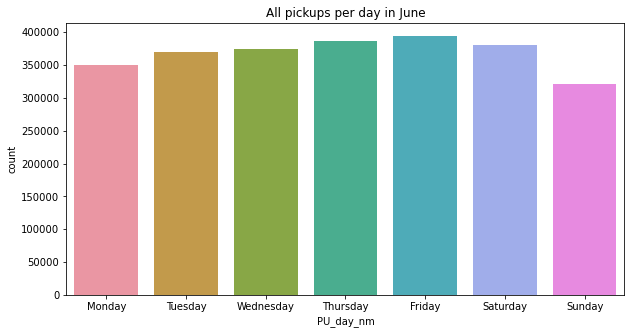

In [1059]:
figure,ax=plt.subplots(figsize=(10,5))
plt.title("All pickups per day in June")
sns.set_palette("husl")
sns.countplot(x='PU_day_nm',data=df_zones_copy,ax=ax)
plt.savefig('pickups_byday.jpg')

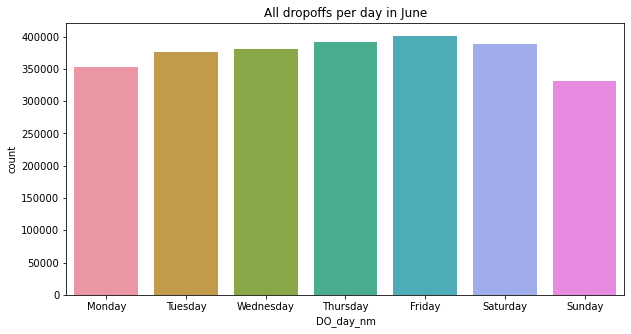

In [518]:
figure,ax=plt.subplots(figsize=(10,5))
plt.title("All dropoffs per day in June")
sns.set_palette("husl")
sns.countplot(x='DO_day_nm',data=df_zones_copy,ax=ax)
plt.savefig('dropoffs_byday.jpg')

In [1205]:
#  Returns tuple of handles, labels for axis ax, after reordering them to conform to the label order `order`, and if unique is True, after removing entries with duplicate labels.
def reorderLegend(ax=None,order=None,unique=False):
    if ax is None: ax=plt.gca()
    handles, labels = ax.get_legend_handles_labels()
    labels, handles = zip(*sorted(zip(labels, handles), key=lambda t: t[0])) # sort both labels and handles by labels
    if order is not None: # Sort according to a given list (not necessarily complete)
        keys=dict(zip(order,range(len(order))))
        labels, handles = zip(*sorted(zip(labels, handles), key=lambda t,keys=keys: keys.get(t[0],np.inf)))
    if unique:  labels, handles= zip(*unique_everseen(zip(labels,handles), key = labels)) # Keep only the first of each handle
    ax.legend(handles, labels)
    return(handles, labels)


def unique_everseen(seq, key=None):
    seen = set()
    seen_add = seen.add
    return [x for x,k in zip(seq,key) if not (k in seen or seen_add(k))]

In [1141]:
df_zones_copy.head(1)

,index,passenger_count,trip_distance,PU_time,DO_time,PU_index,PU_zone,DO_index,DO_zone,passenger_count,...,DO_day,DO_hour,PU_day_nm,DO_day_nm,Norm_x,Norm_y,time_bins,day,hour,day_name
0,0,1,6.6,2016-06-06,2016-06-06 00:16:57,78.0,East Harlem South,169.0,Mott Haven/Port Morris,1,...,6,0,Monday,Monday,0.14408,0.989566,2016-06-06 00:05:00,6,0,Monday


In [336]:
DO_perDay_plot = df_zones_copy.groupby([df_zones_copy['DO_hour'], 'DO_day_nm'])['index'].count().unstack()

In [1138]:
DO_perDay_plot.head()

DO_day_nm,Friday,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday
DO_hour,,,,,,,
0,19057,6643,24021,21558,16079,10542,13465
1,12683,6126,20029,18865,9071,5941,9140
2,7964,3972,16103,15900,4794,3482,4425
3,5204,2578,11594,11626,2915,2235,2729
4,4144,2491,8355,8488,2798,2074,2475


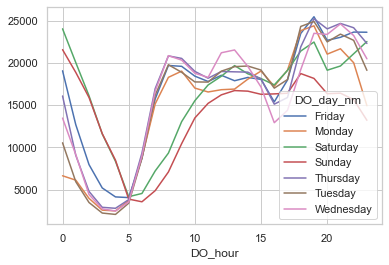

In [1204]:
DO_perDay_plot.plot()

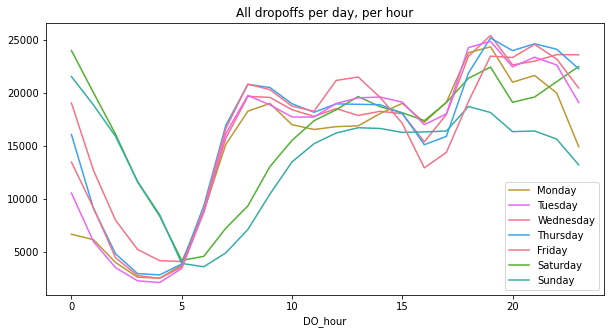

In [341]:
fig,ax=plt.subplots(figsize=(10,5))
DO_perDay_plot.plot(legend = True, ax=ax)
reorderLegend(ax,['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
ax.set_title("All dropoffs per day, per hour")
plt.savefig('pickups_hr.jpg')

It looks like Saturdays and Sundays are pretty different from weekdays, and ride demand goes up throughout the week, peaking on Friday, and then drops on Sunday.

/Users/isaurr/opt/anaconda3/envs/env_pysal/lib/python3.7/site-packages/pyproj/crs/crs.py:55: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
/Users/isaurr/opt/anaconda3/envs/env_pysal/lib/python3.7/site-packages/contextily/tile.py:199: FutureWarning: The url format using 'tileX', 'tileY', 'tileZ' as placeholders is deprecated. Please use '{x}', '{y}', '{z}' instead.
  FutureWarning,


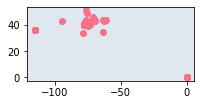

In [519]:
# Finally, note that when we make some scatterplots, we note the outliers are really outliers.
# These are probably the points that we found that weren't in any of the taxi zones:

crs = {'init': 'epsg:3857'}
gdf_PU = gpd.GeoDataFrame(df_PU, crs = crs)
gdf_PU.dtypes

fig, ax = plt.subplots(figsize = (3,3))
gdf_p.plot(ax = ax)
add_basemap(ax, zoom = 12)

In [402]:
df_zones.shape

(2626851, 15)

In [520]:
# Thus, we remove these 'spatial outliers':
df_zones = df_zones.dropna(subset=['DO_index', 'PU_index'])
DO_count = DO_count.dropna(subset=['DO_index', 'PU_index'])
PU_count = PU_count.dropna(subset=['DO_index', 'PU_index'])
df_zones.shape

(2579241, 23)

/Users/isaurr/opt/anaconda3/envs/env_pysal/lib/python3.7/site-packages/pyproj/crs/crs.py:55: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
/Users/isaurr/opt/anaconda3/envs/env_pysal/lib/python3.7/site-packages/contextily/tile.py:199: FutureWarning: The url format using 'tileX', 'tileY', 'tileZ' as placeholders is deprecated. Please use '{x}', '{y}', '{z}' instead.
  FutureWarning,


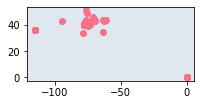

In [521]:
# Finally, note that when we make some scatterplots, we note the outliers remaining are likely just the airports:

crs = {'init': 'epsg:3857'}
gdf_PU = gpd.GeoDataFrame(df_PU, crs = crs)
gdf_PU.dtypes

fig, ax = plt.subplots(figsize = (3,3))
gdf_p.plot(ax = ax)
add_basemap(ax, zoom = 12)

In [522]:
DO_count = DO_count.dropna(subset=['DO_index', 'PU_index'])
keep = list(DO_count['index'])

In [524]:
df_PU = df_PU.take(keep)

IndexError: indices are out-of-bounds

In [525]:
df_DO = df_DO.take(keep)

IndexError: indices are out-of-bounds

In [523]:
print(df_PU.shape,df_DO.shape, len(keep))

(2581974, 25) (2581974, 25) 2581974


# Time for some clustering

## We cluster by pickup, dropoff (4-dim distance) within time bins
Cluster and TSP. 

In [536]:
df_zones.head(1)

,index,passenger_count,trip_distance,PU_time,DO_time,PU_index,PU_zone,DO_index,DO_zone,passenger_count,...,DO_long,DO_lat,PU_day,PU_hour,DO_day,DO_hour,PU_day_nm,DO_day_nm,Norm_x,Norm_y
0,0,1,6.6,2016-06-06,2016-06-06 00:16:57,78.0,East Harlem South,169.0,Mott Haven/Port Morris,1,...,-73.923866,40.807705,6,0,6,0,Monday,Monday,0.14408,0.989566


### Create 'directions'/bearing
To cluster by bearing, we create columns with bearings (360 doesn't work well as we want angles close to 0 and 360 to be considered similar, so we use cosine/sine cols:

In [544]:
def calculate_initial_compass_bearing_vectorized(df_zones):
    
    """ Return compas bearing per ride.  NOTE: I ended up not using this for clustering after all. """
    PU_lat = df_zones['PU_lat']
    PU_long  = df_zones['PU_long'] 
    DO_lat  = df_zones['DO_lat']
    DO_long = df_zones['DO_long']

    lat1 = np.radians(PU_lat)
    lat2 = np.radians(DO_lat)

    diffLong = np.radians(DO_long - DO_lat)

    x = np.sin(diffLong) * np.cos(lat2)
    y = np.cos(lat1) * np.sin(lat2) - (np.sin(lat1)
            * np.cos(lat2) * np.cos(diffLong))

    initial_bearing = np.arctan2(x, y)

    # Now we have the initial bearing but math.atan2 return values
    # from -180° to + 180° which is not what we want for a compass bearing
    # The solution is to normalize the initial bearing as shown below
    initial_bearing = np.degrees(initial_bearing)
    compass_bearing = (initial_bearing + 360) % 360
    
    return pd.DataFrame({'Norm_x': np.cos(compass_bearing), 'Norm_y': np.sin(compass_bearing)})
#    return (math.cos(compass_bearing), math.sin(compass_bearing))
#    return compass_bearing

In [545]:
df_zones_temp = df_zones.apply(calculate_initial_compass_bearing_vectorized)
df_zones['Norm_x'] = df_zones_temp['Norm_x']
df_zones['Norm_y'] = df_zones_temp['Norm_y']

KeyError: 'PU_lat'

In [547]:
# We've created new colmuns Norm_x and Norm_y, we check out these new columns:
df_zones.columns

Index(['index', 'passenger_count', 'trip_distance', 'PU_time', 'DO_time',
       'PU_index', 'PU_zone', 'DO_index', 'DO_zone', 'passenger_count',
       'trip_distance', 'PU_long', 'PU_lat', 'DO_long', 'DO_lat', 'PU_day',
       'PU_hour', 'DO_day', 'DO_hour', 'PU_day_nm', 'DO_day_nm', 'Norm_x',
       'Norm_y'],
      dtype='object')

### Create time bins

In [552]:
df_zones.columns

Index(['index', 'passenger_count', 'trip_distance', 'PU_time', 'DO_time',
       'PU_index', 'PU_zone', 'DO_index', 'DO_zone', 'passenger_count',
       'trip_distance', 'PU_long', 'PU_lat', 'DO_long', 'DO_lat', 'PU_day',
       'PU_hour', 'DO_day', 'DO_hour', 'PU_day_nm', 'DO_day_nm', 'Norm_x',
       'Norm_y'],
      dtype='object')

In [567]:
def n_min_bins(n, df_zones):
    """n_min_bins creates a column of dates rounded to the closest 5 min interval (or n_min interval)"""
    ns5min=n*60*1000000000   # n minutes in nanoseconds 
    return pd.to_datetime(((df_zones['PU_time'].astype(np.int64) // ns5min + 1 ) * ns5min))   

In [571]:
# We add a column of time bins:

df_zones['time_bins'] = n_min_bins(5, df_zones)
df_zones['time_bins'].head(2)

0   2016-06-06 00:05:00
1   2016-06-06 00:05:00
Name: time_bins, dtype: datetime64[ns]

### k-means per time bin (4-dim euclidian distance)

In [ ]:
def distance(origin, destination): #found here https://gist.github.com/rochacbruno/2883505
    """ 4 - dimensional distance for clustering"""
    lat1, lon1 = origin[0],origin[1]
    lat2, lon2 = destination[0],destination[1]
    radius = 3959 # miles
    dlat = np.radians(lat2-lat1)
    dlon = np.radians(lon2-lon1)
    a = np.sin(dlat/2) * np.sin(dlat/2) + np.cos(np.radians(lat1)) \
        * np.cos(np.radians(lat2)) * np.sin(dlon/2) * np.sin(dlon/2)
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1-a))
    d = radius * c

    return d

def distance_2dim(origin, destination):
    lat1, lon1 = origin[0],origin[1]
    lat2, lon2 = destination[0],destination[1]
    radius = 6371 # km
    dlat = np.radians(lat2-lat1)
    dlon = np.radians(lon2-lon1)
    a = np.sin(dlat/2) * np.sin(dlat/2) + np.cos(np.radians(lat1)) \
        * np.cos(np.radians(lat2)) * np.sin(dlon/2) * np.sin(dlon/2)
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1-a))
    d = radius * c

    return d

def create_clusters(number_of_clusters,points):
    kmeans = KMeans(n_clusters=number_of_clusters, random_state=0).fit(points)
    l_array = np.array([[label] for label in kmeans.labels_])
    clusters = np.append(points,l_array,axis=1)
    return clusters

def validate_solution(max_dist,clusters):
    _, __, n_clust = clusters.max(axis=0)
    n_clust = int(n_clust)
    for i in range(n_clust):
        two_d_cluster=clusters[clusters[:,2] == i][:,np.array([True, True, False])]
        if not validate_cluster(max_dist,two_d_cluster):
            return False
        else:
            continue
    return True

def validate_cluster(max_dist,cluster):
    distances = cdist(cluster,cluster, lambda ori,des: int(round(distance(ori,des))))
    print(distances)
    print(30*'-')
    for item in distances.flatten():
        if item > max_dist:
            return False
    return True

In [756]:
def k_means_f(df_zones, n):
    
    # TODO: n_clusters should vary by time of day
    a=df_zones['PU_lat']
    b=df_zones['PU_long']
    c=df_zones['DO_lat']
    d=df_zones['DO_long']

    X=np.column_stack((a,b,c,d))

    kmeans = KMeans(n_clusters = n, init = 'k-means++', random_state = 42)
    kmeans.fit(X) 
    
    # Add cluster label column to dataframe:
    labels = kmeans.labels_
    df_zones['clusters'] = labels
    
    return df_zones

In [ ]:
# To run k-means, we run:
df_zones_test = df_zones.groupby('time_bins').apply(k_means_f)


### selecting n_cluster variable:

A hacky way to find out what a good number of clusters is to choose a few different time bins, and see what value for n_clusters looks good for those specific time bins. This is not ideal, but it is slightly better than guessing, for now.
TODO - Improve selection of n_cluster variable by testing over time bins. 

In the meantime, use the elbow & silhouette methods to select a good val for n_clusters.

In [607]:
def elbow_g(df_zones):
    
    a=df_zones['PU_lat']
    b=df_zones['PU_long']
    c=df_zones['DO_lat']
    d=df_zones['DO_long']

    X=np.column_stack((a,b,c,d))

    sum_of_squared_distances = []
    
    K = range(1,50)
    
    for k in K:
        print(k, end=' ')
        kmeans = KMeans(n_clusters=k).fit(X)
        sum_of_squared_distances.append(kmeans.inertia_)
        
    plt.plot(K, sum_of_squared_distances, 'bx-')
    plt.xlabel('k')
    plt.ylabel('sum_of_squared_distances')
    plt.title('Elbow Method For Optimal k')
    


1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 

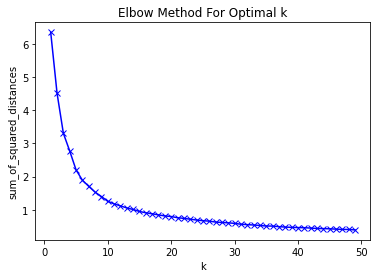

In [608]:
subsetdf = df_zones.loc[df_zones['time_bins'] == '2016-06-06 09:10:00' ]
subsetdf.shape
elbow_g(subsetdf)

1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 

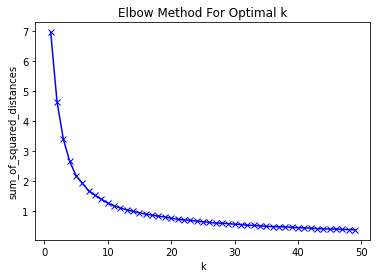

In [609]:
subsetdf = df_zones.loc[df_zones['time_bins'] == '2016-06-10 17:10:00' ]
subsetdf.shape
elbow_g(subsetdf)

1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 

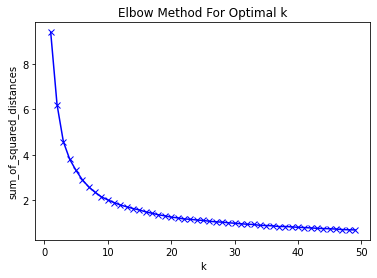

In [610]:
subsetdf = df_zones.loc[df_zones['time_bins'] == '2016-06-10 22:10:00' ]
subsetdf.shape
elbow_g(subsetdf)

Examine sillhouette score too:

In [619]:
def sil_g(df_zones):
    
    a=df_zones['PU_lat']
    b=df_zones['PU_long']
    c=df_zones['DO_lat']
    d=df_zones['DO_long']

    X=np.column_stack((a,b,c,d))
    
    sil = []
    K_sil = range(2,50)
    # minimum 2 clusters required, to define dissimilarity
    for k in K_sil:
        print(k, end=' ')
        kmeans = KMeans(n_clusters = k).fit(X)
        labels = kmeans.labels_
        sil.append(silhouette_score(X, labels, metric = 'euclidean'))

    plt.plot(K_sil, sil, 'bx-')
    plt.xlabel('k')
    plt.ylabel('silhouette_score')
    plt.title('Silhouette Method For Optimal k')
    plt.show()

(1636, 24)
2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 

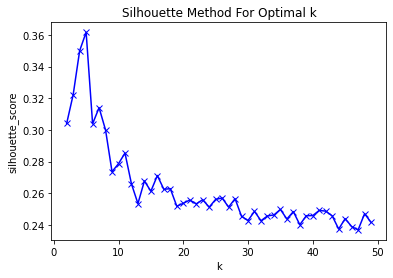

In [620]:
subsetdf = df_zones.loc[df_zones['time_bins'] == '2016-06-10 09:10:00' ]
print(subsetdf.shape)
sil_g(subsetdf)

(1388, 24)
2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 

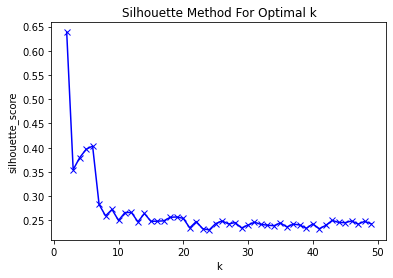

In [621]:
subsetdf = df_zones.loc[df_zones['time_bins'] == '2016-06-10 17:10:00' ]
print(subsetdf.shape)
sil_g(subsetdf)

(1964, 24)
2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 

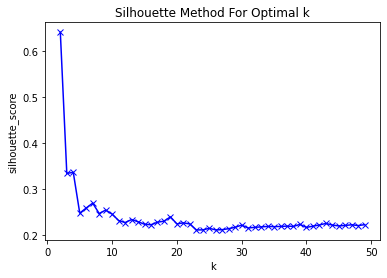

In [622]:
subsetdf = df_zones.loc[df_zones['time_bins'] == '2016-06-10 22:10:00' ]
print(subsetdf.shape)
sil_g(subsetdf)

We're getting some conflicting ansers here, but it looks like k=5 or k=10 might be ok-ish guesses for n_cluster.

Let's dig a bit further by looking at what some of these centroid 'centers' look like:

In [729]:
def plot_centres(df_zones, k):
    
    """Plot cluster centres for clusters on df_zones, k-means with input val k as # of clusters.
    Pickup centroids are ploted with a dot, and dropoffs are ploted with a star. """
    
    a=df_zones['PU_lat']
    b=df_zones['PU_long']
    c=df_zones['DO_lat']
    d=df_zones['DO_long']

    X=np.column_stack((a,b,c,d))
    
    kmeans = KMeans(n_clusters = k).fit(X)
    centers = np.array(kmeans.cluster_centers_)
    labels = kmeans.labels_
    plt.plot()
    plt.title('k means centroids')
    # colors = ['b', 'r', 'g', 'c', 'm', 'y', 'k']
    colors = cm.rainbow(np.linspace(0, 1, len(centers)))

    for i, l in enumerate(centers):
        plt.plot(centers[i][0], centers[i][1], color=colors[i], marker = ".")
        plt.plot(centers[i][2], centers[i][3], color=colors[i], marker = "*")
#         plt.xlim([0, 10])
#         plt.ylim([0, 10])
    return centers
  #  plt.scatter(centers[:,0], centers[:,1], marker="x", color='r')
  #  plt.show()

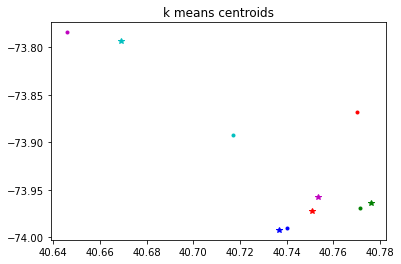

In [669]:
subsetdf = df_zones.loc[df_zones['time_bins'] == '2016-06-10 17:10:00' ]
centers = plot_centres(subsetdf,5)

In [739]:
def make_centres_gdf(subsetdf, n):
    
    centres = plot_centres(subsetdf,n)
    
    c_x = []
    c_y = []
    col = []
    mark = []
    
    for i in range(0, len(centres)):
        c_x.append(centres[i][0])
        c_y.append(centres[i][1])
        c_x.append(centres[i][2])
        c_y.append(centres[i][3])
        col.append(i)
        col.append(i)
        mark.append(0)
        mark.append(1)
        
    c = {'c_x':c_x,'c_y':c_y, 'col': col, 'mark':mark}
    cdf = pd.DataFrame(c)
    
    gdf_centres = gpd.GeoDataFrame(
    cdf, geometry=gpd.points_from_xy(cdf.c_y, cdf.c_x))
    return gdf_centres

In [794]:
gdf_centres

,c_x,c_y,col,mark,geometry
0,40.776848,-73.963581,0,.,POINT (-73.96358 40.77685)
1,40.787795,-73.949270,0,*,POINT (-73.94927 40.78780)
2,40.756503,-73.980110,1,.,POINT (-73.98011 40.75650)
3,40.734475,-73.994223,1,*,POINT (-73.99422 40.73447)
4,40.639347,-73.793397,2,.,POINT (-73.79340 40.63935)
5,40.679426,-73.796019,2,*,POINT (-73.79602 40.67943)
6,40.645692,-73.784271,3,.,POINT (-73.78427 40.64569)
7,40.754328,-73.965478,3,*,POINT (-73.96548 40.75433)
8,40.760163,-73.949486,4,.,POINT (-73.94949 40.76016)
9,40.674009,-73.799769,4,*,POINT (-73.79977 40.67401)


/Users/isaurr/opt/anaconda3/envs/env_pysal/lib/python3.7/site-packages/contextily/tile.py:199: FutureWarning: The url format using 'tileX', 'tileY', 'tileZ' as placeholders is deprecated. Please use '{x}', '{y}', '{z}' instead.
  FutureWarning,


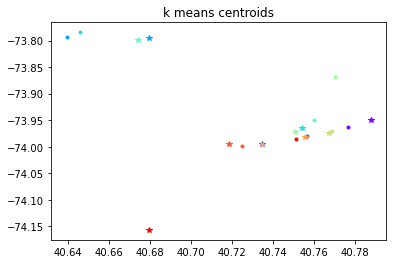

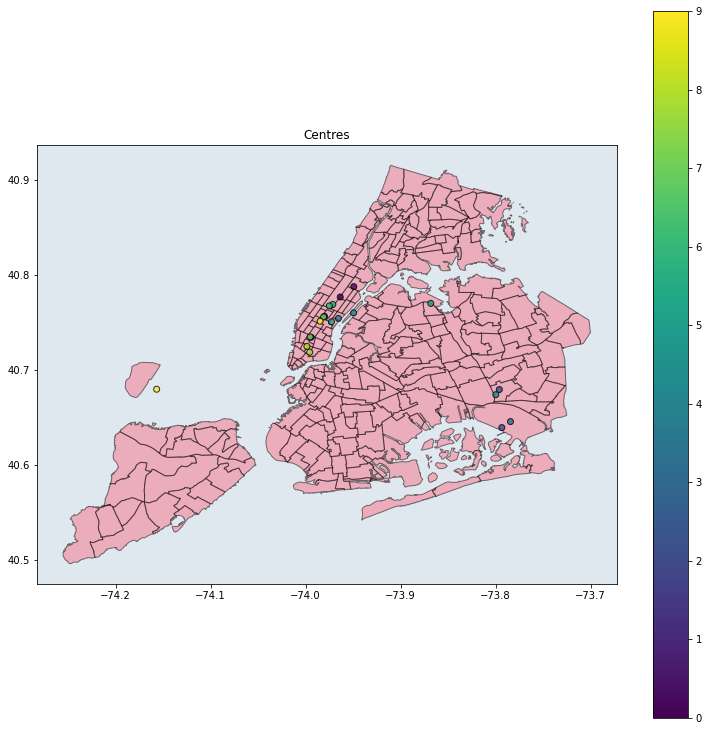

In [755]:
gdf_centres = make_centres_gdf(subsetdf, 10)

markers = ['.','*']
fig, ax = plt.subplots(figsize = (13,13))
zones.plot( categorical=True, ax = ax, alpha = 0.5, edgecolor = 'k')
#gdf_centres.plot(column='col', categorical=False, ax = ax, alpha = 0.8, edgecolor = 'k', marker = markers['mark'])
gdf_centres.plot(column='col', categorical=False, ax = ax, alpha = 0.8, edgecolor = 'k', legend = True)

plt.title("Centres")
add_basemap(ax, zoom = 12)

Examine one time bin and clusters

In [1231]:
def build_cluster_df(df_zones, n):

    df_zones = df_zones.loc[:,~df_zones.columns.duplicated()]
    df_zones_c = df_zones.groupby('time_bins').apply(k_means_f,n)
    df_clusters = df_zones_c.groupby(['time_bins', 'clusters']).apply(cluster_summary)
    
    return df_clusters



def cluster_summary(cluster):
    """ Takes in a section of a dataframe (slice by time bin and by cluster).
    """    
    
    ############## Create trip_time column:
    cluster['trip_time'] = cluster['DO_time']-cluster['PU_time']
    cluster['trip_time'] = cluster['trip_time'].dt.seconds
    
    ############## Calculates mean distance/trip-time of trips per cluster
    mean_trip_dist = np.mean(cluster['trip_distance'])
    mean_trip_time = np.mean(cluster['trip_time'])
    
    ############## Calculates num of drivers required originally/num passengers transported
    num_drivers = cluster.shape[0]
    total_passengers = np.sum(cluster['passenger_count'])
    
    ############## Calculates avg PU/DO and average distance to PU/DO for PU/DO point in cluster
    pu_long_mean = np.mean(cluster['PU_long'])
    pu_lat_mean = np.mean(cluster['PU_lat'])
    do_long_mean = np.mean(cluster['DO_long'])
    do_lat_mean = np.mean(cluster['DO_lat'])
    
    pu_cent = [pu_lat_mean, pu_long_mean]
    do_cent = [do_lat_mean, do_long_mean]
    
    pu_origin = [cluster['PU_lat'],cluster['PU_long']]
    do_origin = [cluster['DO_lat'],cluster['DO_long']]
    
    pu_dist_mean = np.mean(distance(pu_origin, pu_cent))
    do_dist_mean = np.mean(distance(do_origin, do_cent))
    
    
    
    do_tour = 3 * do_dist_mean
    pu_tour = 3 * pu_dist_mean
    
    # Distance to round up/drop off customers
    passenger_tour = min(do_tour,pu_tour)

#     # Calculating pu_dist_mean
#     # single number, mean distance to centroid over all points in `cluster`
#     pu_long_diff = np.square(cluster['PU_long'] - pu_long_mean)
#     pu_lat_diff = np.square(cluster['PU_lat'] - pu_lat_mean)
#     pu_dist = np.sqrt(pu_long_diff + pu_lat_diff)
#     pu_dist_mean = np.mean(pu_dist) 

    new_trip_dist = passenger_tour + mean_trip_dist
        
    new_trip_time = weird_division(new_trip_dist*mean_trip_time, mean_trip_dist*360)
    
    speed_mph = weird_division(mean_trip_dist*360,mean_trip_time)

#     # Calculating do_dist_mean
#     # single number, mean distance to centroid over all points in `cluster`
#     do_long_diff = np.square(cluster['DO_long'] - do_long_mean)
#     do_lat_diff = np.square(cluster['DO_lat'] - do_lat_mean)
#     do_dist = np.sqrt(do_long_diff + do_lat_diff)
#     do_dist_mean = np.mean(pu_dist) 

    
    return pd.Series({
        'old_mean_trip_dist': mean_trip_dist,
        'old_mean_trip_time': mean_trip_time/360,
        'total_passengers': total_passengers,
        'old_num_drivers': num_drivers,
        'new_num_drivers': ceildiv(total_passengers,4),
        'do_dist_mean': do_dist_mean,
        'pu_dist_mean': pu_dist_mean,
        'passenger_tour': passenger_tour,
        # passenger_tour + mean_trip_dist:
        'new_trip_dist': new_trip_dist,
        'speed_mph': speed_mph,
        # Distance/speed(in mph):
        'new_trip_time': new_trip_time,
        'old_time_worked': (mean_trip_time*num_drivers)/360,
        # new_trip_time * new_num_drivers:
        'new_time_worked': (new_trip_time)*ceildiv(total_passengers,4),
        'difference': (mean_trip_time*num_drivers)/360 - (new_trip_time)*ceildiv(total_passengers,4)
    })


# Helper functions for build_cluster_df:

def weird_division(n, d):
    return n / d if d else 0

def ceildiv(a, b):
    return -(-a // b)

def distance(origin, destination): #adapted from https://gist.github.com/rochacbruno/2883505
    lat1, lon1 = origin[0],origin[1]
    lat2, lon2 = destination[0],destination[1]
    radius = 3959 # miles
    dlat = np.radians(lat2-lat1)
    dlon = np.radians(lon2-lon1)
    a = np.sin(dlat/2) * np.sin(dlat/2) + np.cos(np.radians(lat1)) \
        * np.cos(np.radians(lat2)) * np.sin(dlon/2) * np.sin(dlon/2)
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1-a))
    d = radius * c

    return d

In [1232]:
clusters_df_summary_10 = build_cluster_df(df_zones, 10)

In [1233]:
clusters_df_summary_10 = clusters_df_summary_10.reset_index()

In [1234]:
clusters_df_summary_10.head()

,time_bins,clusters,old_mean_trip_dist,old_mean_trip_time,total_passengers,old_num_drivers,new_num_drivers,do_dist_mean,pu_dist_mean,passenger_tour,new_trip_dist,speed_mph,new_trip_time,old_time_worked,new_time_worked,difference
0,2016-06-06 00:05:00,0,6.195192,2.757585,96.0,52.0,24.0,1.594386,1.840728,4.783157,10.978349,2.246600,4.886650,143.394444,117.279596,26.114848
1,2016-06-06 00:05:00,1,17.530784,4.576253,68.0,51.0,17.0,3.021381,0.429412,1.288237,18.819021,3.830816,4.912535,233.388889,83.513100,149.875789
2,2016-06-06 00:05:00,2,4.689091,2.782828,98.0,55.0,25.0,1.886285,1.894499,5.658854,10.347945,1.685009,6.141180,153.055556,153.529508,-0.473952
3,2016-06-06 00:05:00,3,2.185613,1.465591,269.0,155.0,68.0,0.867671,0.952706,2.603014,4.788627,1.491284,3.211077,227.166667,218.353215,8.813452
4,2016-06-06 00:05:00,4,10.015455,3.276326,65.0,44.0,17.0,2.862184,0.487015,1.461046,11.476500,3.056917,3.754273,144.158333,63.822647,80.335687


In [1235]:
clusters_df_summary_10.isna().sum()

time_bins             0
clusters              0
old_mean_trip_dist    0
old_mean_trip_time    0
total_passengers      0
old_num_drivers       0
new_num_drivers       0
do_dist_mean          0
pu_dist_mean          0
passenger_tour        0
new_trip_dist         0
speed_mph             0
new_trip_time         0
old_time_worked       0
new_time_worked       0
difference            0
dtype: int64

# Total saved efficiency

In [1236]:
clusters_df_summary_10.shape

(20160, 16)

In [1238]:
print(sum(clusters_df_summary_10['old_time_worked']) - sum(clusters_df_summary_10['new_time_worked']))
print(sum(clusters_df_summary_10['old_time_worked']))
print(sum(clusters_df_summary_10['new_time_worked']))

872571.3737575561
7228718.17500001
6356146.801242454


For n = 10 clusters:

In [1239]:
clusters_df_summary_12 = build_cluster_df(df_zones,12)

In [1240]:
clusters_df_summary_12 = clusters_df_summary_12.reset_index()

In [1241]:
clusters_df_summary_12.shape

(24192, 16)

In [1242]:
print(sum(clusters_df_summary_12['old_time_worked']) - sum(clusters_df_summary_12['new_time_worked']))\

1043622.1403217074


In [1243]:
clusters_df_summary_10_copy = clusters_df_summary_10.copy()
clusters_df_summary_10_copy.dtypes

time_bins             datetime64[ns]
clusters                       int64
old_mean_trip_dist           float64
old_mean_trip_time           float64
total_passengers             float64
old_num_drivers              float64
new_num_drivers              float64
do_dist_mean                 float64
pu_dist_mean                 float64
passenger_tour               float64
new_trip_dist                float64
speed_mph                    float64
new_trip_time                float64
old_time_worked              float64
new_time_worked              float64
difference                   float64
dtype: object

# Efficiency by time/location

In [1244]:
clusters_df_summary_10_copy['day'] = clusters_df_summary_10_copy['time_bins'].dt.day
clusters_df_summary_10_copy['hour'] = clusters_df_summary_10_copy['time_bins'].dt.hour
clusters_df_summary_10_copy['day_name'] = clusters_df_summary_10_copy['time_bins'].dt.day_name()
clusters_df_summary_10_copy.tail(100)

,time_bins,clusters,old_mean_trip_dist,old_mean_trip_time,total_passengers,old_num_drivers,new_num_drivers,do_dist_mean,pu_dist_mean,passenger_tour,new_trip_dist,speed_mph,new_trip_time,old_time_worked,new_time_worked,difference,day,hour,day_name
20060,2016-06-12 23:15:00,0,1.723507,1.218532,218.0,134.0,55.0,1.092166,1.073945,3.221836,4.945344,1.414413,3.496394,163.283333,192.301680,-29.018347,12,23,Sunday
20061,2016-06-12 23:15:00,1,17.643729,5.042420,98.0,59.0,25.0,2.197921,0.462095,1.386285,19.030014,3.499060,5.438608,297.502778,135.965196,161.537582,12,23,Sunday
20062,2016-06-12 23:15:00,2,3.643285,2.558374,226.0,137.0,57.0,1.200141,0.898037,2.694112,6.337397,1.424063,4.450223,350.497222,253.662730,96.834492,12,23,Sunday
20063,2016-06-12 23:15:00,3,5.464000,2.621389,68.0,50.0,17.0,1.605472,1.942260,4.816415,10.280415,2.084391,4.932095,131.069444,83.845608,47.223837,12,23,Sunday
20064,2016-06-12 23:15:00,4,4.832615,2.820556,104.0,65.0,26.0,1.798134,1.919554,5.394402,10.227017,1.713356,5.968998,183.336111,155.193938,28.142173,12,23,Sunday
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20155,2016-06-13 00:00:00,5,0.557500,0.436111,8.0,4.0,2.0,0.326867,0.644336,0.980600,1.538100,1.278344,1.203197,1.744444,2.406395,-0.661950,13,0,Monday
20156,2016-06-13 00:00:00,6,0.562500,0.350694,9.0,4.0,3.0,0.478045,0.485736,1.434134,1.996634,1.603960,1.244815,1.402778,3.734446,-2.331668,13,0,Monday
20157,2016-06-13 00:00:00,7,0.875000,0.497222,4.0,4.0,1.0,0.657306,0.580077,1.740232,2.615232,1.759777,1.486116,1.988889,1.486116,0.502773,13,0,Monday
20158,2016-06-13 00:00:00,8,0.805000,0.572222,3.0,2.0,1.0,0.229820,0.210325,0.630976,1.435976,1.406796,1.020742,1.144444,1.020742,0.123702,13,0,Monday


In [1245]:
clusters_df_summary_10_copy.head(1)

,time_bins,clusters,old_mean_trip_dist,old_mean_trip_time,total_passengers,old_num_drivers,new_num_drivers,do_dist_mean,pu_dist_mean,passenger_tour,new_trip_dist,speed_mph,new_trip_time,old_time_worked,new_time_worked,difference,day,hour,day_name
0,2016-06-06 00:05:00,0,6.195192,2.757585,96.0,52.0,24.0,1.594386,1.840728,4.783157,10.978349,2.2466,4.88665,143.394444,117.279596,26.114848,6,0,Monday


In [1246]:
df_copy = clusters_df_summary_10_copy

In [1247]:
df_copy.day_name.unique()

array(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday',
       'Sunday'], dtype=object)

In [1248]:
df_copy_day = df_copy.copy().groupby('day_name').agg({'difference':'sum'})
df_copy_day = df_copy_day.reset_index()

In [1249]:
df_copy_day

,day_name,difference
0,Friday,144935.814239
1,Monday,145277.128412
2,Saturday,68401.626838
3,Sunday,82828.069310
4,Thursday,161174.254364
5,Tuesday,134292.750367
6,Wednesday,135661.730227


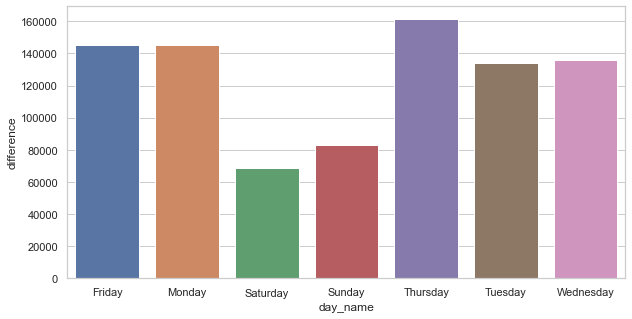

In [1250]:
figure,ax=plt.subplots(figsize=(10,5))
ax = sns.barplot(x="day_name", y="difference", data=df_copy_day)



In [1251]:
df_copy_day_2 = df_copy.copy().groupby('day_name').agg({'old_time_worked':'sum', 'new_time_worked':'sum'})
df_copy_day_2 = df_copy_day_2.reset_index()
df_copy_day_2

,day_name,old_time_worked,new_time_worked
0,Friday,1.137596e+06,9.926602e+05
1,Monday,9.588456e+05,8.135685e+05
2,Saturday,9.909797e+05,9.225781e+05
3,Sunday,7.166283e+05,6.338002e+05
4,Thursday,1.182649e+06,1.021475e+06
5,Tuesday,1.058836e+06,9.245431e+05
6,Wednesday,1.183184e+06,1.047522e+06


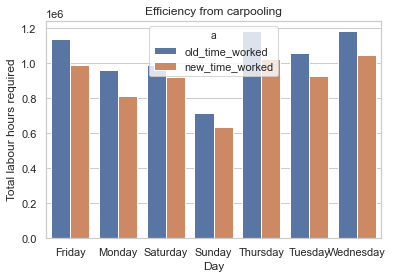

In [1252]:
df_copy_day_2 = df_copy_day_2.melt('day_name', var_name='a', value_name='b')


ax=sns.barplot(x='day_name', y='b', hue='a', data=df_copy_day_2)
plt.xlabel("Day")
plt.ylabel("Total labour hours required")
plt.title("Efficiency from carpooling")
plt.savefig('saved_day.jpg')

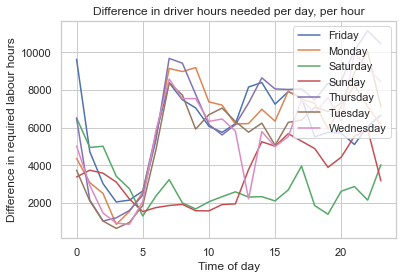

In [1254]:
df_copy = clusters_df_summary_10_copy
df_copy_m = df_copy.groupby(['hour', 'day_name'])['difference'].sum().unstack().plot()

#df_copy_m = df_copy.copy().groupby('hour','day_name').agg({'difference':'sum'})
df_copy_m.plot()
plt.xlabel("Time of day")
plt.ylabel("Difference in required labour hours")
plt.title("Difference in driver hours needed per day, per hour")
ax = plt.gca()
ax.legend(loc = 'upper right')
plt.savefig('day_hrSdiff.jpg')


In [ ]:
fig,ax=plt.subplots(figsize=(10,5))
DO_perDay_plot.plot(legend = True, ax=ax)
reorderLegend(ax,['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
ax.set_title("All dropoffs per day, per hour")
ax.legend(loc = 'upper right')
plt.savefig('pickups_hr.jpg')
